<a href="https://colab.research.google.com/github/lauramoraes/Text_Mining/blob/master/Thrones2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Thrones2Vec

© Yuriy Guts, 2016

Using only the raw text of [A Song of Ice and Fire](https://en.wikipedia.org/wiki/A_Song_of_Ice_and_Fire), we'll derive and explore the semantic properties of its words.

Source: https://github.com/YuriyGuts/thrones2vec/blob/master/Thrones2Vec.ipynb

## Imports

In [0]:
from __future__ import absolute_import, division, print_function

In [0]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re
import urllib2
import urllib

In [0]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Set up logging**

In [0]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

**Download NLTK tokenizer models (only the first time)**

In [6]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Prepare Corpus

**Load books from files**

In [0]:
# book_filenames = sorted(glob.glob("data/game-of-thrones-books/*.txt"))
url_base = "https://raw.githubusercontent.com/lauramoraes/Text_Mining/master/data/game-of-thrones-books/"
book_filenames = ["001ssb.txt", "002ssb.txt", "003ssb.txt", "004ssb.txt", "005ssb.txt"]

In [17]:
print("Found books:")
book_filenames

Found books:


['001ssb.txt', '002ssb.txt', '003ssb.txt', '004ssb.txt', '005ssb.txt']

**Combine the books into one string**

In [24]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    book_file = urllib.urlretrieve(url_base + book_filename, book_filename)
    with codecs.open(book_filename, "r", "latin-1") as book_file:
      corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading '001ssb.txt'...
Corpus is now 1607894 characters long

Reading '002ssb.txt'...
Corpus is now 3392960 characters long

Reading '003ssb.txt'...
Corpus is now 5714229 characters long

Reading '004ssb.txt'...
Corpus is now 7437782 characters long

Reading '005ssb.txt'...
Corpus is now 9778333 characters long



**Split the corpus into sentences**

In [0]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [0]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [0]:
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [0]:
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [29]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

He was an old man, past fifty, and he had seen the lordlings come and go.
[u'He', u'was', u'an', u'old', u'man', u'past', u'fifty', u'and', u'he', u'had', u'seen', u'the', u'lordlings', u'come', u'and', u'go']


In [30]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 1,814,415 tokens


## Train Word2Vec

In [0]:

# Dimensionality of the resulting word vectors.
num_features = 300

# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
seed = 1

In [0]:
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [48]:
thrones2vec.build_vocab(sentences)

2019-06-11 18:48:33,564 : INFO : collecting all words and their counts
2019-06-11 18:48:33,565 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-06-11 18:48:33,619 : INFO : PROGRESS: at sentence #10000, processed 111316 words, keeping 8120 word types
2019-06-11 18:48:33,654 : INFO : PROGRESS: at sentence #20000, processed 220924 words, keeping 11146 word types
2019-06-11 18:48:33,690 : INFO : PROGRESS: at sentence #30000, processed 329240 words, keeping 13327 word types
2019-06-11 18:48:33,726 : INFO : PROGRESS: at sentence #40000, processed 438003 words, keeping 15508 word types
2019-06-11 18:48:33,758 : INFO : PROGRESS: at sentence #50000, processed 546631 words, keeping 17067 word types
2019-06-11 18:48:33,795 : INFO : PROGRESS: at sentence #60000, processed 663833 words, keeping 19225 word types
2019-06-11 18:48:33,831 : INFO : PROGRESS: at sentence #70000, processed 779270 words, keeping 20423 word types
2019-06-11 18:48:33,866 : INFO : PROGRESS: at s

In [36]:
print("Word2Vec vocabulary length:", len(thrones2vec.wv.vocab))

Word2Vec vocabulary length: 17265


**Start training, this might take a minute or two...**

In [49]:
thrones2vec.train(sentences, total_examples=thrones2vec.corpus_count, epochs=thrones2vec.epochs)

2019-06-11 18:48:38,486 : INFO : training model with 2 workers on 17265 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2019-06-11 18:48:39,578 : INFO : EPOCH 1 - PROGRESS: at 9.19% examples, 105759 words/s, in_qsize 4, out_qsize 0
2019-06-11 18:48:40,696 : INFO : EPOCH 1 - PROGRESS: at 19.44% examples, 107982 words/s, in_qsize 4, out_qsize 0
2019-06-11 18:48:41,778 : INFO : EPOCH 1 - PROGRESS: at 29.49% examples, 109956 words/s, in_qsize 3, out_qsize 0
2019-06-11 18:48:42,878 : INFO : EPOCH 1 - PROGRESS: at 39.40% examples, 110541 words/s, in_qsize 4, out_qsize 0
2019-06-11 18:48:43,973 : INFO : EPOCH 1 - PROGRESS: at 48.83% examples, 111005 words/s, in_qsize 4, out_qsize 0
2019-06-11 18:48:45,069 : INFO : EPOCH 1 - PROGRESS: at 58.57% examples, 111350 words/s, in_qsize 4, out_qsize 0
2019-06-11 18:48:46,086 : INFO : EPOCH 1 - PROGRESS: at 67.00% examples, 111642 words/s, in_qsize 4, out_qsize 0
2019-06-11 18:48:47,094 : INFO : EPOCH 1 - PROGRESS: at 73.0

(7005263, 9072075)

**Save to file, can be useful later**

In [0]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [51]:
thrones2vec.save(os.path.join("trained", "thrones2vec.w2v"))

2019-06-11 18:50:43,157 : INFO : saving Word2Vec object under trained/thrones2vec.w2v, separately None
2019-06-11 18:50:43,159 : INFO : not storing attribute vectors_norm
2019-06-11 18:50:43,162 : INFO : not storing attribute cum_table
/usr/local/lib/python2.7/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2019-06-11 18:50:43,375 : INFO : saved trained/thrones2vec.w2v


## Explore the trained model.

In [52]:
thrones2vec = w2v.Word2Vec.load(os.path.join("trained", "thrones2vec.w2v"))

2019-06-11 18:50:52,225 : INFO : loading Word2Vec object from trained/thrones2vec.w2v
/usr/local/lib/python2.7/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2019-06-11 18:50:52,356 : INFO : loading vocabulary recursively from trained/thrones2vec.w2v.vocabulary.* with mmap=None
2019-06-11 18:50:52,358 : INFO : loading wv recursively from trained/thrones2vec.w2v.wv.* with mmap=None
2019-06-11 18:50:52,360 : INFO : setting ignored attribute vectors_norm to None
2019-06-11 18:50:52,363 : INFO : loading trainables recursively from trained/thrones2vec.w2v.trainables.* with mmap=None
2019-06-11 18:50:52,366 : INFO : setting ignored attribute cum_table to None
2019-06-11 18:50:52,369 : INFO : loaded trained/thrones2

### Compress the word vectors into 2D space and plot them

In [0]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [56]:
all_word_vectors_matrix = thrones2vec.wv.syn0

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


**Train t-SNE, this could take a minute or two...**

In [0]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

**Plot the big picture**

In [0]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [61]:
points.head(10)

,word,x,y
0,fawn,-4.466846,-2.791641
1,raining,-35.751858,1.097186
2,writings,2.444810,-30.089582
3,Ysilla,-25.764658,-1.254568
4,Rory,-26.544758,-0.474207
5,hordes,35.171898,0.686066
6,mustachio,-25.956724,-22.001469
7,Greyjoy,49.122543,21.276064
8,yellow,-55.359093,-32.128918
9,four,37.635265,6.330912


In [0]:
sns.set_context("poster")

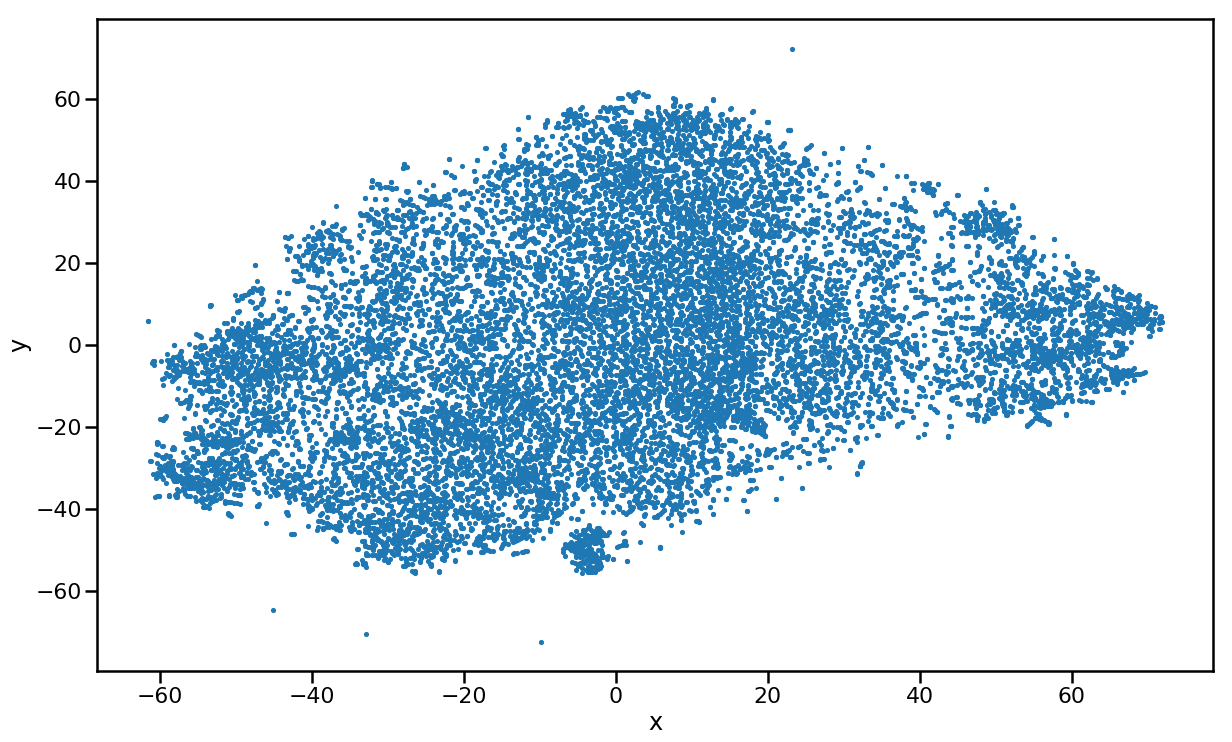

In [63]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

**Zoom in to some interesting places**

In [0]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
#     return slice
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

**People related to Kingsguard ended up together**


In [109]:
points[points['word'] == 'Ned']

,word,x,y
16515,Ned,37.32201,30.479431


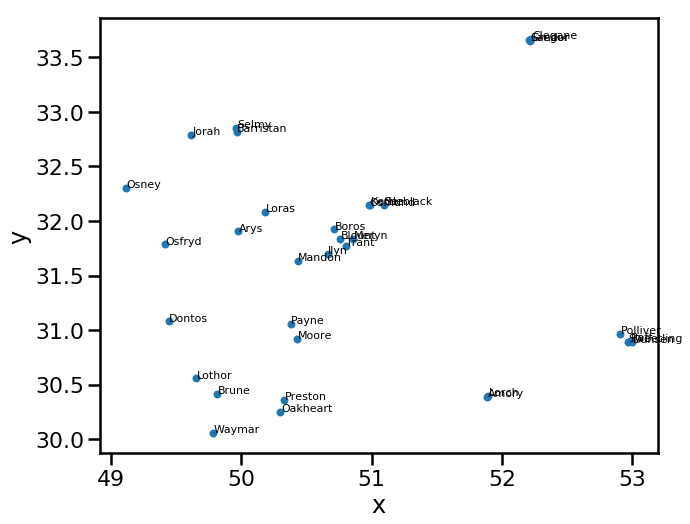

In [94]:
plot_region(x_bounds=(49, 53), y_bounds=(30, 34))

**The Starks as well**

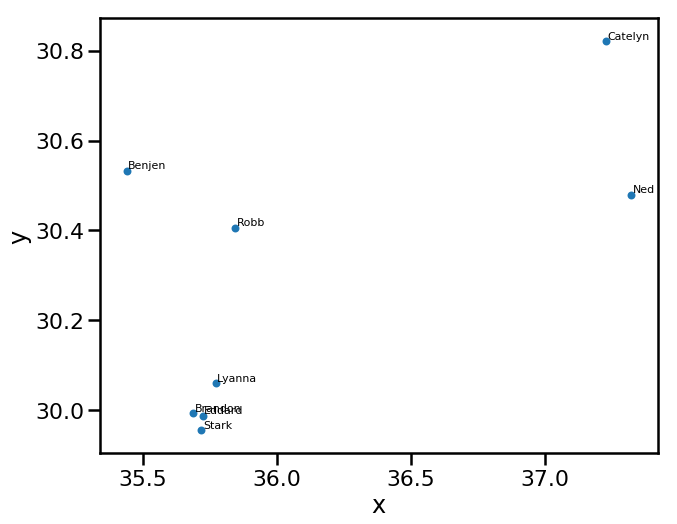

In [114]:
plot_region(x_bounds=(35, 38), y_bounds=(29, 31))

**Food products are grouped nicely as well.**

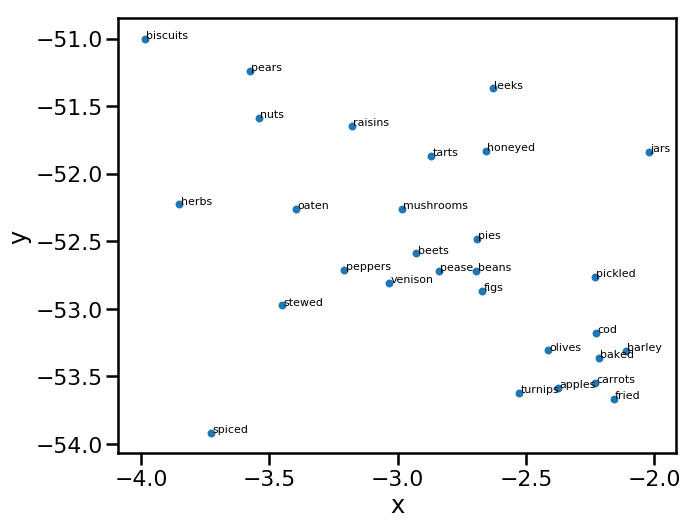

In [100]:
plot_region(x_bounds=(-4, -2), y_bounds=(-54, -51))

### Explore semantic similarities between book characters

**Words closest to the given word**

In [116]:
thrones2vec.most_similar("Stark")

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[(u'Eddard', 0.7221307754516602),
 (u'Lyanna', 0.6779835224151611),
 (u'Winterfell', 0.6539649963378906),
 (u'executed', 0.6392621397972107),
 (u'Hornwood', 0.6290276646614075),
 (u'Brandon', 0.6179719567298889),
 (u'Benjen', 0.6128507852554321),
 (u'Roslin', 0.6092551350593567),
 (u'direwolf', 0.6088361740112305),
 (u'Tully', 0.6082375645637512)]

In [102]:
thrones2vec.most_similar("Aerys")

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[(u'Jaehaerys', 0.8075859546661377),
 (u'II', 0.7683902382850647),
 (u'Daeron', 0.7452603578567505),
 (u'reign', 0.7422258853912354),
 (u'Mad', 0.7404768466949463),
 (u'Beggar', 0.7311717867851257),
 (u'Conquest', 0.7301287651062012),
 (u'Cruel', 0.7253029942512512),
 (u'appointment', 0.7202398777008057),
 (u'Unworthy', 0.7044795751571655)]

In [103]:
thrones2vec.most_similar("direwolf")

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[(u'SHAGGYDOG', 0.672808051109314),
 (u'Rickon', 0.6622729301452637),
 (u'wolf', 0.6521313190460205),
 (u'pup', 0.6394908428192139),
 (u'Gatehouse', 0.6252898573875427),
 (u'GHOST', 0.6201658248901367),
 (u'crannogman', 0.6148181557655334),
 (u'Stark', 0.6088361740112305),
 (u'Othor', 0.6058881282806396),
 (u'Ghost', 0.6038668751716614)]

**Linear relationships between word pairs**

In [0]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [105]:
nearest_similarity_cosmul("Stark", "Winterfell", "Riverrun")
nearest_similarity_cosmul("Jaime", "sword", "wine")
nearest_similarity_cosmul("Arya", "Nymeria", "dragons")

Stark is related to Winterfell, as Tully is related to Riverrun
Jaime is related to sword, as Tyrion is related to wine
Arya is related to Nymeria, as Dany is related to dragons


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  after removing the cwd from sys.path.


u'Dany'